In [1]:
%load_ext autoreload
%autoreload 2

# Analyzing the trained model

In [2]:
# import os; os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".99"

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from typing import Any, Callable, Sequence, Union
import numpy as np

import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

import jax
from jax import lax, random, numpy as jnp
from flax.core import freeze, unfreeze, FrozenDict
from flax import linen as nn
from flax import struct
from flax.training import train_state
from flax.training import orbax_utils

import optax
import orbax.checkpoint

from clu import metrics
from ml_collections import ConfigDict

from einops import reduce, rearrange
import wandb
from iqadatasets.datasets import *
from fxlayers.layers import *
from fxlayers.layers import GaussianLayerGamma, GaborLayerLogSigma_
from fxlayers.initializers import *
from JaxPlayground.utils.constraints import *
from JaxPlayground.utils.wandb import *

2023-12-01 11:03:31.797075: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-01 11:03:33.327753: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-12-01 11:03:36.365141: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-12-01 11:03:36.365190: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: mlui02.ific.uv.es
2023-12-01 11:03:36.365203: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: mlui02.ific.uv.es
2023-12-01 11:03:36.365300: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagno

In [4]:
# jax.config.update("jax_debug_nans", False)

## Generate the stimuli

We will be generating an image with a given background frequency and a given stimuli frequency.

In [5]:
import matplotlib.pyplot as plt

In [6]:
IMG_SHAPE = (384,512,3)

In [7]:
def control_lum_contrast(image, L, C):
    # CONTROL_LUM_CONTRAST sets the average luminance and RMSE sinus-like contrast for a natural image 
    img_mean = jnp.mean(image)
    img_std = jnp.std(image)*jnp.sqrt(2)
    if img_std == 0:
        img_std = 1
    new_image = (image - img_mean)/img_std
    new_image = L + C*L*new_image
    return new_image

In [8]:
def generate_sinusoid(img_size, freq, theta, phase, fs, lum=None, contrast=None, normalize_energy=False, zero_mean=False):
    def sinusoid(x, y, freq, theta, phase, normalize_energy=False, zero_mean=False):        
        ## Obtain the normalization coeficient
        g = jnp.cos(2*jnp.pi*freq*(x*jnp.cos(theta)+y*jnp.sin(theta)) + phase)
        g = jnp.where(zero_mean, g - g.mean(), g)
        E_norm = jnp.where(normalize_energy, jnp.sqrt(jnp.sum(g**2)), 1.)
        return g/E_norm
    x, y = jnp.meshgrid(jnp.linspace(0,img_size[1]/fs,num=img_size[1]), jnp.linspace(0,img_size[0]/fs,num=img_size[0]))
    sin = sinusoid(x-img_size[0]/fs/2, y-img_size[1]/fs/2, freq, theta, phase, normalize_energy, zero_mean)
    if (lum is None) and (contrast is None): return sin
    elif (lum is not None) and (contrast is None): return control_lum_contrast(sin, L=lum, C=sin.std())
    elif (lum is None) and (contrast is not None): return control_lum_contrast(sin, L=sin.mean(), C=contrast)
    else: return control_lum_contrast(sin, L=lum, C=contrast)

In [9]:
def get_range(arr): return arr.min(), arr.max()

(Array(-0.19745556, dtype=float32), Array(0.19279072, dtype=float32))


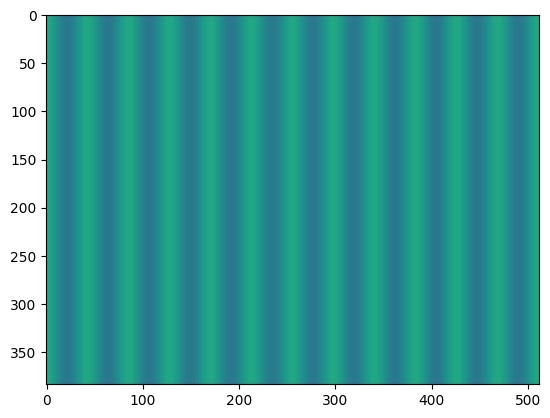

In [10]:
# background = generate_sinusoid((384,384), freq=3, theta=0, phase=0, fs=128)
background = generate_sinusoid(IMG_SHAPE, freq=3, theta=0, phase=0, fs=128, lum=None, contrast=100)
plt.imshow(background, vmin=-1, vmax=1)
print(get_range(background))
plt.show()

The first step will be generating noise of a given frequency for the background. The easiest way to acomplish that is through the Fourier Transform:

In [11]:
import cmath
from perceptualtests.utils import spatio_temp_freq_domain

In [12]:
def noise(fx2,# Frequency space x dominion.
          fy2, # Frequency space y dominion.
          fm, # Minimum frequency.
          fM, # Maximum frequency.
          angle, # Angle of rotation in Fourier.
          delta_a, # Width taken in Fourier.
          seed=random.PRNGKey(42), # Random seed
          ):

    a_m = -delta_a/2
    a_M = delta_a/2

    f = jnp.sqrt(fx2**2+fy2**2)
    a = 180*jnp.arctan2(fy2,fx2)/jnp.pi

    F_noise_f = 1*((f>fm) & (f<fM))
    F_noise_a = 1*(((a>a_m+angle) & (a<a_M+angle)) | ((a>a_m+angle+180) & (a<a_M+angle+180)) | ((a>a_m+angle-180) & (a<a_M+angle-180)) )   

    F_noise = F_noise_f*F_noise_a

    nf = F_noise*jnp.exp(cmath.sqrt(-1)*(2*jnp.pi*random.uniform(seed, shape=(fx2.shape[0], fx2.shape[1]))))
    nx = jnp.fft.ifft2(jnp.fft.ifftshift(nf)).real

    return nx, nf, F_noise  

In [13]:
# fig, axes = plt.subplots(1,3, figsize=(16,4))
# axes[0].imshow(nx)
# axes[1].imshow(nf.real)
# axes[2].imshow(F_noise)
# plt.show()

In [14]:
def generate_noise_freq(IMG_SHAPE, fm, fM, angle, delta_a, fs, lum=None, contrast=None, seed=random.PRNGKey(42)):
    x, y, _, ffx, ffy, _ = spatio_temp_freq_domain(*IMG_SHAPE[:-1], 1, fs/2, fs/2, 1)
    nx, nf, F_noise = noise(ffx, ffy, fm=fm, fM=fM, angle=angle, delta_a=delta_a, seed=seed)
    if (lum is None) and (contrast is None): return nx
    elif (lum is not None) and (contrast is None): return control_lum_contrast(nx, L=lum, C=nx.std())
    elif (lum is None) and (contrast is not None): return control_lum_contrast(nx, L=nx.mean(), C=contrast)
    else: return control_lum_contrast(nx, L=lum, C=contrast)

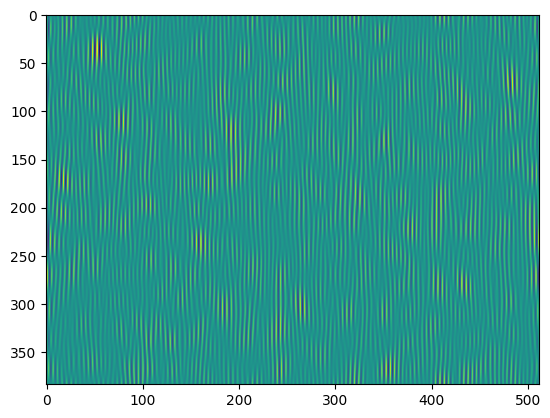

In [15]:
noise_freq = generate_noise_freq(IMG_SHAPE, fm=12, fM=16, angle=0, delta_a=10, fs=128)
plt.imshow(noise_freq)
plt.show()

Now that we have both the sinusoid and the controlled-frequency noise, we can put them together to build the final stimuli to be used:

In [16]:
## Background config ##
fm = 12
fM = 16
angle = 0
delta_a = 10
fs = 128
lum_bg, contrast_bg = 50, 10

## Sinusoid config ##
freq = 3
theta = 0
phase = 0
fs = 128
lum_s, contrast_s = 50, 10

background = generate_noise_freq(IMG_SHAPE, fm=fm, fM=fM, angle=angle, delta_a=delta_a, fs=fs, lum=lum_bg, contrast=contrast_bg)
sinusoid = generate_sinusoid(jnp.array(IMG_SHAPE)//4, freq=3, theta=0, phase=0, fs=128, lum=lum_s, contrast=contrast_s)

In [17]:
background.shape, sinusoid.shape

((384, 512), (96, 128))

In [18]:
def insert_image(img1, img2):
    """Inserts img2 at the middle of img1."""
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    return img1.at[h1//2-h2//2:h1//2+h2//2, w1//2-w2//2:w1//2+w2//2].set(img2)

In [19]:
def insert_image_addition(img1, img2):
    """Inserts img2 at the middle of img1."""
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    return img1.at[h1//2-h2//2:h1//2+h2//2, w1//2-w2//2:w1//2+w2//2].set(img1[h1//2-h2//2:h1//2+h2//2, w1//2-w2//2:w1//2+w2//2] + img2)

In [20]:
def adjust_range(arr): return (arr-arr.min())/(arr.max()-arr.min())

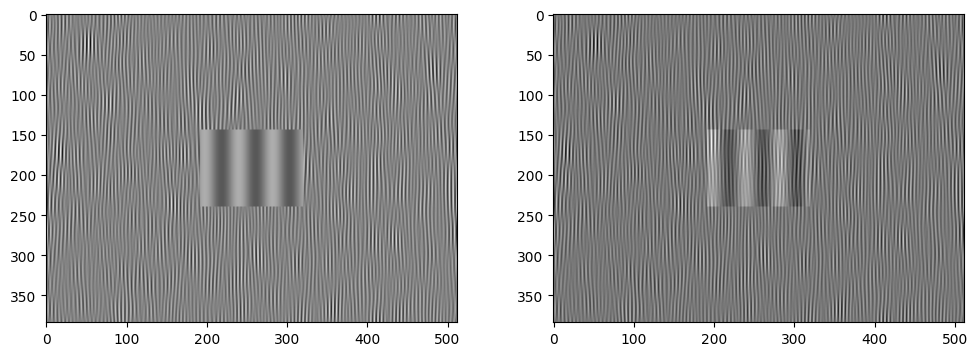

In [21]:
l = insert_image(background, sinusoid)
l = adjust_range(l)
k = insert_image_addition(background, sinusoid)
k = adjust_range(k)
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].imshow(l, cmap="gray")
axes[1].imshow(k, cmap="gray")
plt.show()

In [22]:
config = {
    "BATCH_SIZE": 64,
    "EPOCHS": 500,
    "LEARNING_RATE": 3e-3,
    "SEED": 42,
    "GDN_CLIPPING": True,
    "NORMALIZE_PROB": False,
    "NORMALIZE_ENERGY": True,
    "ZERO_MEAN": True,
    "USE_BIAS": False,
    "CS_KERNEL_SIZE": 21,
    "GABOR_KERNEL_SIZE": 31,
    "N_SCALES": 4,
    "N_ORIENTATIONS": 8,
}
config = ConfigDict(config)
config

BATCH_SIZE: 64
CS_KERNEL_SIZE: 21
EPOCHS: 500
GABOR_KERNEL_SIZE: 31
GDN_CLIPPING: true
LEARNING_RATE: 0.003
NORMALIZE_ENERGY: true
NORMALIZE_PROB: false
N_ORIENTATIONS: 8
N_SCALES: 4
SEED: 42
USE_BIAS: false
ZERO_MEAN: true

In [23]:
id = "zxmnjuqq"

In [24]:
api = wandb.Api()
prev_run = api.run(f"jorgvt/PerceptNet_v15/{id}")

In [25]:
config = ConfigDict(prev_run.config["_fields"])

In [26]:
for file in prev_run.files():
    file.download(root=prev_run.dir, replace=True)

## Define the model we're going to use

> It's going to be a very simple model just for demonstration purposes.

In [35]:
def pad_same_from_kernel_size(inputs, kernel_size, mode):
    return jnp.pad(inputs,
                   [[0,0],
                    [(kernel_size-1)//2, (kernel_size-1)//2],
                    [(kernel_size-1)//2, (kernel_size-1)//2],
                    [0,0]],
                    mode=mode)

In [36]:
class PerceptNet(nn.Module):
    """IQA model inspired by the visual system."""

    @nn.compact
    def __call__(self,
                 inputs, # Assuming fs = 128 (cpd)
                 **kwargs,
                 ):
        ## (Independent) Color equilibration (Gamma correction)
        ## Might need to be the same for each number
        ## bias = 0.1 / kernel = 0.5
        outputs = GDN(kernel_size=(1,1), apply_independently=True)(inputs)
        
        ## Color (ATD) Transformation
        outputs = nn.Conv(features=3, kernel_size=(1,1), use_bias=False)(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        
        ## GDN Star A - T - D [Separated]
        outputs = GDN(kernel_size=(1,1), apply_independently=True)(outputs)

        ## Center Surround (DoG)
        ## Initialized so that 3 are positives and 3 are negatives and no interaction between channels is present
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.CS_KERNEL_SIZE, mode="symmetric")
        outputs = CenterSurroundLogSigmaK(features=3, kernel_size=config.CS_KERNEL_SIZE, fs=21, use_bias=False, padding="VALID")(outputs, **kwargs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))

        ## GDN per channel with mean substraction in T and D (Spatial Gaussian Kernel)
        ### fs = 32 / kernel_size = (11,11) -> 0.32 > 0.02 --> OK!
        ## TO-DO: - Spatial Gaussian Kernel (0.02 deg) -> fs = 64/2 & 0.02*64/2 = sigma (px) = 0.69
        outputs = GDN(kernel_size=(1,1), apply_independently=True)(outputs)

        ## GaborLayer per channel with GDN mixing only same-origin-channel information
        ### [Gaussian] sigma = 0.2 (deg) fs = 32 / kernel_size = (21,21) -> 21/32 = 0.66 --> OK!
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.GABOR_KERNEL_SIZE, mode="symmetric")
        outputs = GaborLayerLogSigma_(n_scales=config.N_SCALES, n_orientations=config.N_ORIENTATIONS, kernel_size=config.GABOR_KERNEL_SIZE, fs=32, xmean=config.GABOR_KERNEL_SIZE/32/2, ymean=config.GABOR_KERNEL_SIZE/32/2, strides=1, padding="VALID", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, zero_mean=config.ZERO_MEAN, use_bias=config.USE_BIAS)(outputs, **kwargs)
        
        ## Final GDN mixing Gabor information (?)
        outputs = GDN(kernel_size=(1,1), apply_independently=False)(outputs)
        return outputs

## Define the metrics with `clu`

In [37]:
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    loss: metrics.Average.from_output("loss")

By default, `TrainState` doesn't include metrics, but it's very easy to subclass it so that it does:

In [38]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    state: FrozenDict

We'll define a function that initializes the `TrainState` from a module, a rng key and some optimizer:

In [39]:
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    variables = module.init(key, jnp.ones(input_shape))
    state, params = variables.pop('params')
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        state=state,
        tx=tx,
        metrics=Metrics.empty()
    )

## Defining the training step

> We want to write a function that takes the `TrainState` and a batch of data can performs an optimization step.

In [40]:
def pearson_correlation(vec1, vec2):
    vec1 = vec1.squeeze()
    vec2 = vec2.squeeze()
    vec1_mean = vec1.mean()
    vec2_mean = vec2.mean()
    num = vec1-vec1_mean
    num *= vec2-vec2_mean
    num = num.sum()
    denom = jnp.sqrt(jnp.sum((vec1-vec1_mean)**2))
    denom *= jnp.sqrt(jnp.sum((vec2-vec2_mean)**2))
    return num/denom

In [41]:
@jax.jit
def train_step(state, batch):
    """Train for a single step."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=True)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=True)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos), updated_state
    
    (loss, updated_state), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    metrics_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    state = state.replace(state=updated_state)
    return state

In their example, they don't calculate the metrics at the same time. I think it is kind of a waste because it means having to perform a new forward pass, but we'll follow as of now. Let's define a function to perform metric calculation:

In [42]:
@jax.jit
def compute_metrics(*, state, batch):
    """Obtaining the metrics for a given batch."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=False)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=False)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos)
    
    metrics_updates = state.metrics.single_from_model_output(loss=loss_fn(state.params))
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    return state

## Loading the weights

In [43]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), optax.adam(config.LEARNING_RATE), input_shape=(1,384,512,3))
# state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))

In [44]:
import flax

In [45]:
def check_trainable(path):
    return False
    # return ("A" in path) or ("alpha_achrom" in path) or ("alpha_chrom_rg" in path) or ("alpha_chrom_yb" in path)

In [46]:
trainable_tree = freeze(flax.traverse_util.path_aware_map(lambda path, v: "non_trainable" if check_trainable(path)  else "trainable", state.params))

In [47]:
optimizers = {
    "trainable": optax.adam(learning_rate=config.LEARNING_RATE),
    "non_trainable": optax.set_to_zero(),
}

In [48]:
tx = optax.multi_transform(optimizers, trainable_tree)

In [49]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), tx, input_shape=(1,384,512,3))
# state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))

Instantiate the checkpointer to reload the already trained model:

In [54]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(state)

In [55]:
state = orbax_checkpointer.restore(f"{prev_run.dir}/model-best", item=state)

In [56]:
param_count = sum(x.size for x in jax.tree_util.tree_leaves(state.params))
param_count

4242

In [61]:
kernel = state.state["precalc_filter"]["GaborLayerLogSigma__0"]["kernel"]

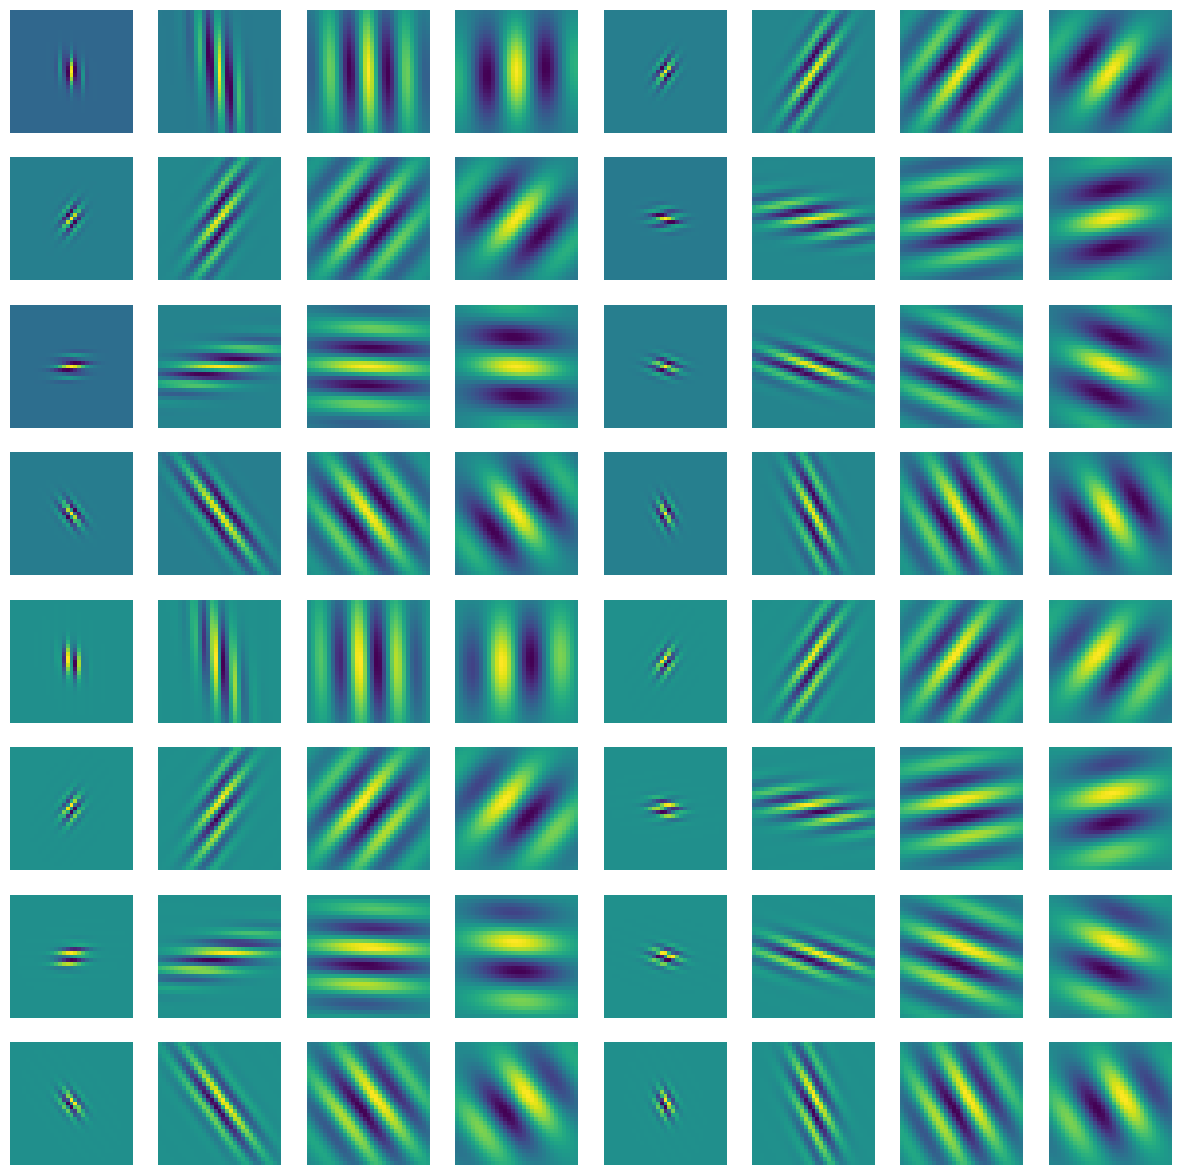

In [63]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(kernel[:,:,0,i])
    ax.axis("off")
plt.show()

## Forward pass of the generated stimuli

In [64]:
from functools import partial

In [65]:
@jax.jit
def forward(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False)

In [66]:
@jax.jit
def forward_intermediates(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False, capture_intermediates=True)

In [ ]:
kk = jnp.repeat(k[None,:,:,None], repeats=3, axis=-1)
kk.shape

(1, 384, 512, 3)

In [77]:
import cv2

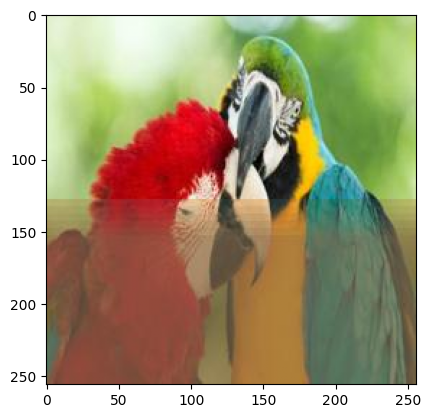

In [80]:
kk = cv2.imread("loritos_jesus_2.jpeg")
kk = cv2.cvtColor(kk, cv2.COLOR_BGR2RGB)/255.
plt.imshow(kk)
plt.show()
kk = kk[None,:]

In [81]:
%%time
outputs, extras = forward_intermediates(state, kk)
outputs.shape

CPU times: user 1.93 s, sys: 49.7 ms, total: 1.98 s
Wall time: 399 ms


(1, 64, 64, 64)

## Checking the weights

In [82]:
state.params.keys()

frozen_dict_keys(['CenterSurroundLogSigmaK_0', 'Conv_0', 'GDN_0', 'GDN_1', 'GDN_2', 'GDN_3', 'GaborLayerLogSigma__0'])

### Gamma Correction

In [98]:
layer_name = "GDN_0"
state.params[layer_name]

FrozenDict({
    Conv_0: {
        bias: array([0.10824087, 0.02773898, 0.11342502], dtype=float32),
        kernel: array([[[[0.16418591, 0.        , 0.        ]]]], dtype=float32),
    },
})

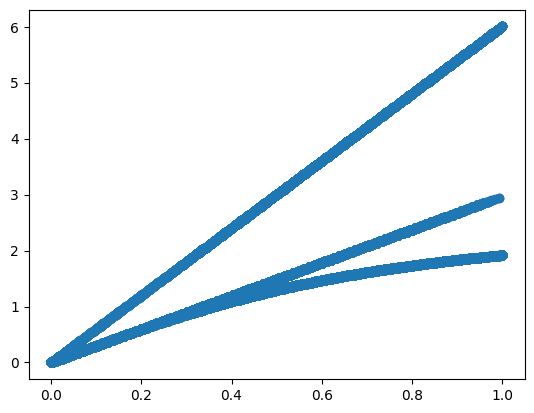

In [84]:
plt.scatter(kk.ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

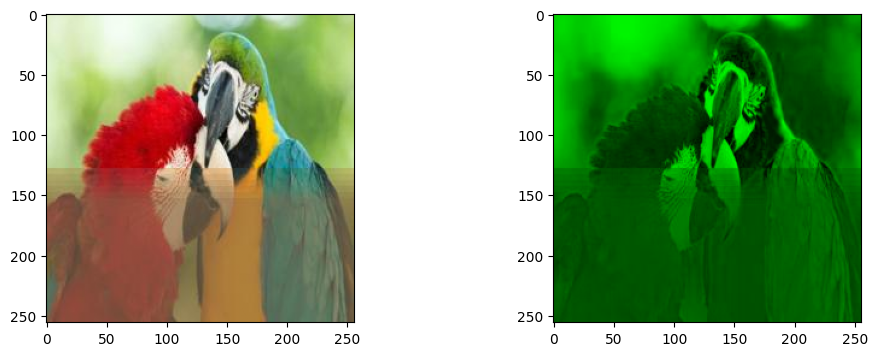

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].imshow(kk[0])
axes[1].imshow(extras["intermediates"][layer_name]["__call__"][0][0]/extras["intermediates"][layer_name]["__call__"][0][0].max())
plt.show()

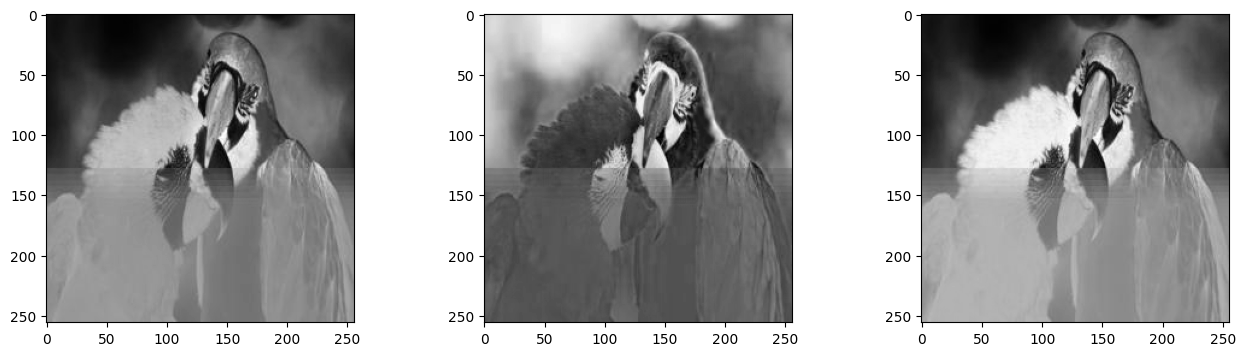

In [89]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
for i, ax in enumerate(axes):
    ax.imshow(extras["intermediates"][layer_name]["__call__"][0][0,:,:,i], cmap="gray")
plt.show()

### J & H

In [100]:
prev_layer = "GDN_0"
layer_name = "Conv_0"

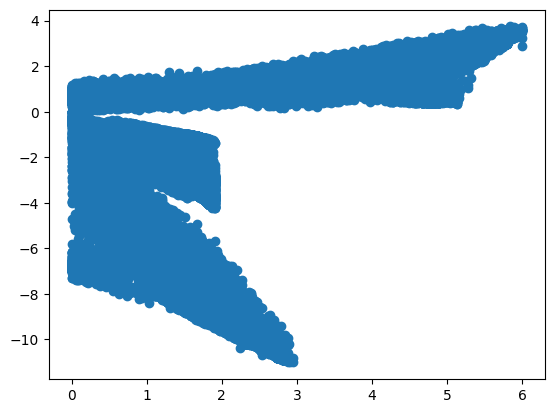

In [101]:
plt.scatter(extras["intermediates"][prev_layer]["__call__"][0].ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

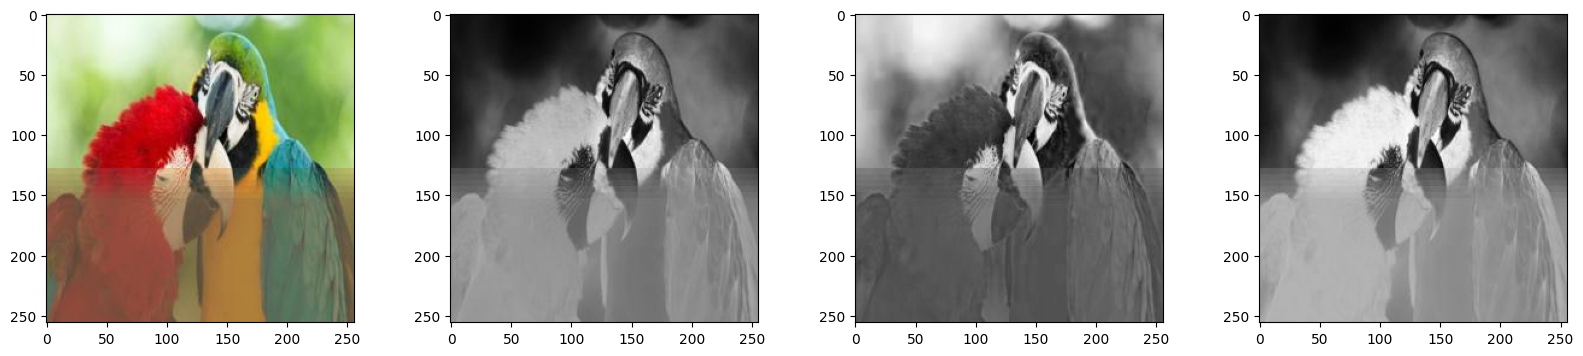

In [97]:
fig, axes = plt.subplots(1, 4, figsize=(20,4))
axes[0].imshow(kk[0])
for i, ax in enumerate(axes[1:]):
    ax.imshow(extras["intermediates"][layer_name]["__call__"][0][0,:,:,i], cmap="gray")
plt.show()

### DN 1

In [102]:
prev_layer = "Conv_0"
layer_name = "GDN_1"
state.params[layer_name]

FrozenDict({
    Conv_0: {
        bias: array([0.7308053, 0.7252311, 1.0294789], dtype=float32),
        kernel: array([[[[1.6881302e-01, 0.0000000e+00, 4.1465380e-05]]]], dtype=float32),
    },
})

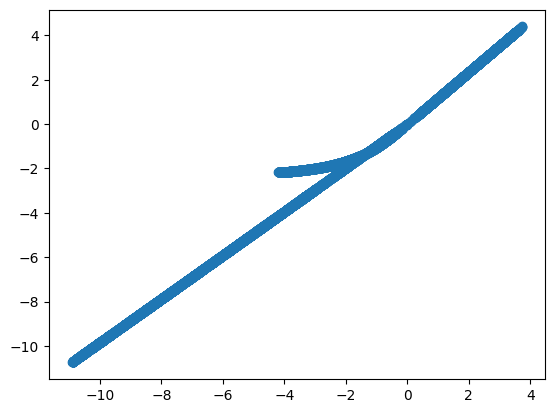

In [104]:
plt.scatter(nn.max_pool(extras["intermediates"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2)).ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

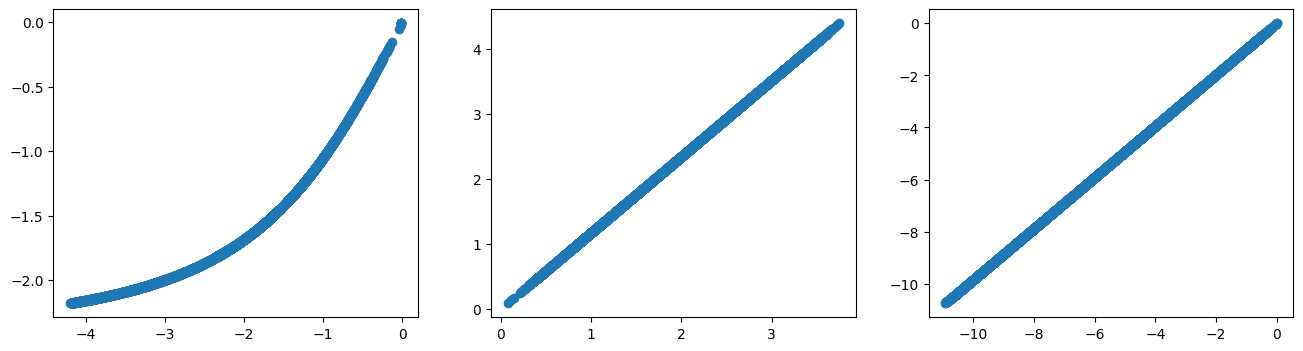

In [106]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
for i, ax in enumerate(axes):
    ax.scatter(nn.max_pool(extras["intermediates"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2))[0,:,:,i].ravel(),
               extras["intermediates"][layer_name]["__call__"][0][0,:,:,i].ravel())
plt.show()

### CSF (DoG)

In [107]:
prev_layer = "GDN_1"
layer_name = "CenterSurroundLogSigmaK_0"
state.params[layer_name]

FrozenDict({
    A: array([1.1292175 , 0.02598892, 0.6850117 , 0.23969784, 1.3668944 ,
           0.07392187, 0.01426675, 0.        , 1.0900834 ], dtype=float32),
    K: array([1.0117217, 1.0023504, 1.0028682, 1.378523 , 1.0155958, 1.225538 ,
           1.0174037, 1.0372037, 1.0022051], dtype=float32),
    logsigma: array([-1.9202219, -2.4483237, -2.5924325, -1.432964 , -1.8453557,
           -1.4423746, -2.3987346, -1.821246 , -2.6059945], dtype=float32),
})

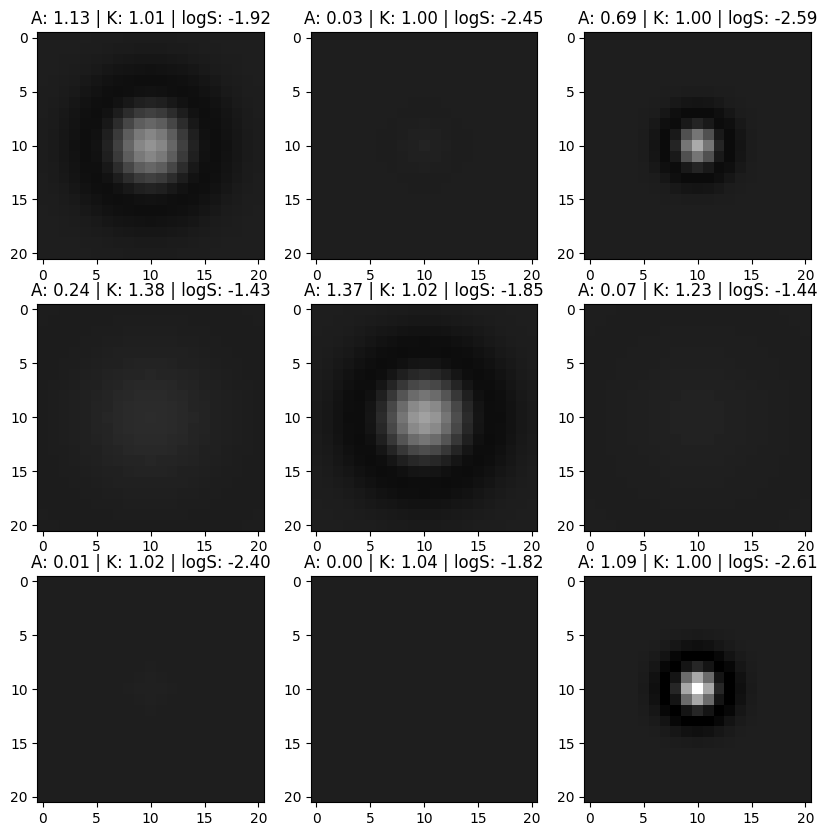

In [116]:
fig, axes = plt.subplots(3, 3, figsize=(10,10))
m, M = state.state["precalc_filter"][layer_name]["kernel"].min(), state.state["precalc_filter"][layer_name]["kernel"].max()
k = 0
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(state.state["precalc_filter"][layer_name]["kernel"][:,:,i,j], vmin=m, vmax=M, cmap="gray")
        ax.set_title(f'A: {state.params[layer_name]["A"][k]:.2f} | K: {state.params[layer_name]["K"][k]:.2f} | logS: {state.params[layer_name]["logsigma"][k]:.2f}')
        k += 1
plt.show()

### DN (2)

In [117]:
prev_layer = "CenterSurroundLogSigmaK_0"
layer_name = "GDN_2"
state.params[layer_name]

FrozenDict({
    Conv_0: {
        bias: array([0.5882042 , 0.56352556, 0.8472637 ], dtype=float32),
        kernel: array([[[[1.7778384e-02, 5.3628391e-01, 1.0355020e-04]]]], dtype=float32),
    },
})

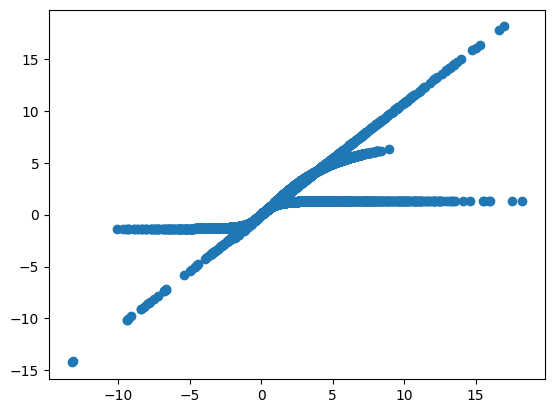

In [118]:
plt.scatter(nn.max_pool(extras["intermediates"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2)).ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

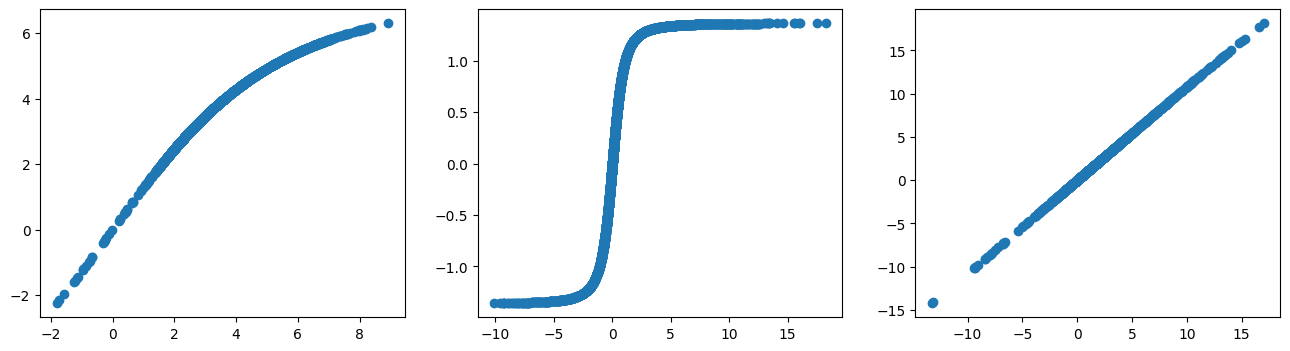

In [119]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
for i, ax in enumerate(axes):
    ax.scatter(nn.max_pool(extras["intermediates"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2))[0,:,:,i].ravel(),
               extras["intermediates"][layer_name]["__call__"][0][0,:,:,i].ravel())
plt.show()

### Gabor

In [121]:
prev_layer = "GDN_2"
layer_name = "GaborLayerLogSigma__0"
state.params[layer_name]

FrozenDict({
    freq: array([10.842353 ,  6.108862 ,  3.1242595,  1.9762431], dtype=float32),
    logsigmax2: array([-5.722296, -4.441838, -2.394233, -2.084108], dtype=float32),
    logsigmay2: array([-4.7717996, -2.1663594, -2.057171 , -2.7004242], dtype=float32),
    sigma_theta: array([-0.26441994,  0.36483383,  0.3354997 ,  1.7893913 ,  1.2864994 ,
            1.6958874 ,  2.5051858 ,  2.9110947 ], dtype=float32),
    theta: array([-0.02533763,  0.650616  ,  0.7054938 ,  1.3894039 ,  1.6180115 ,
            1.9326952 ,  2.5008426 ,  2.6030688 ], dtype=float32),
})

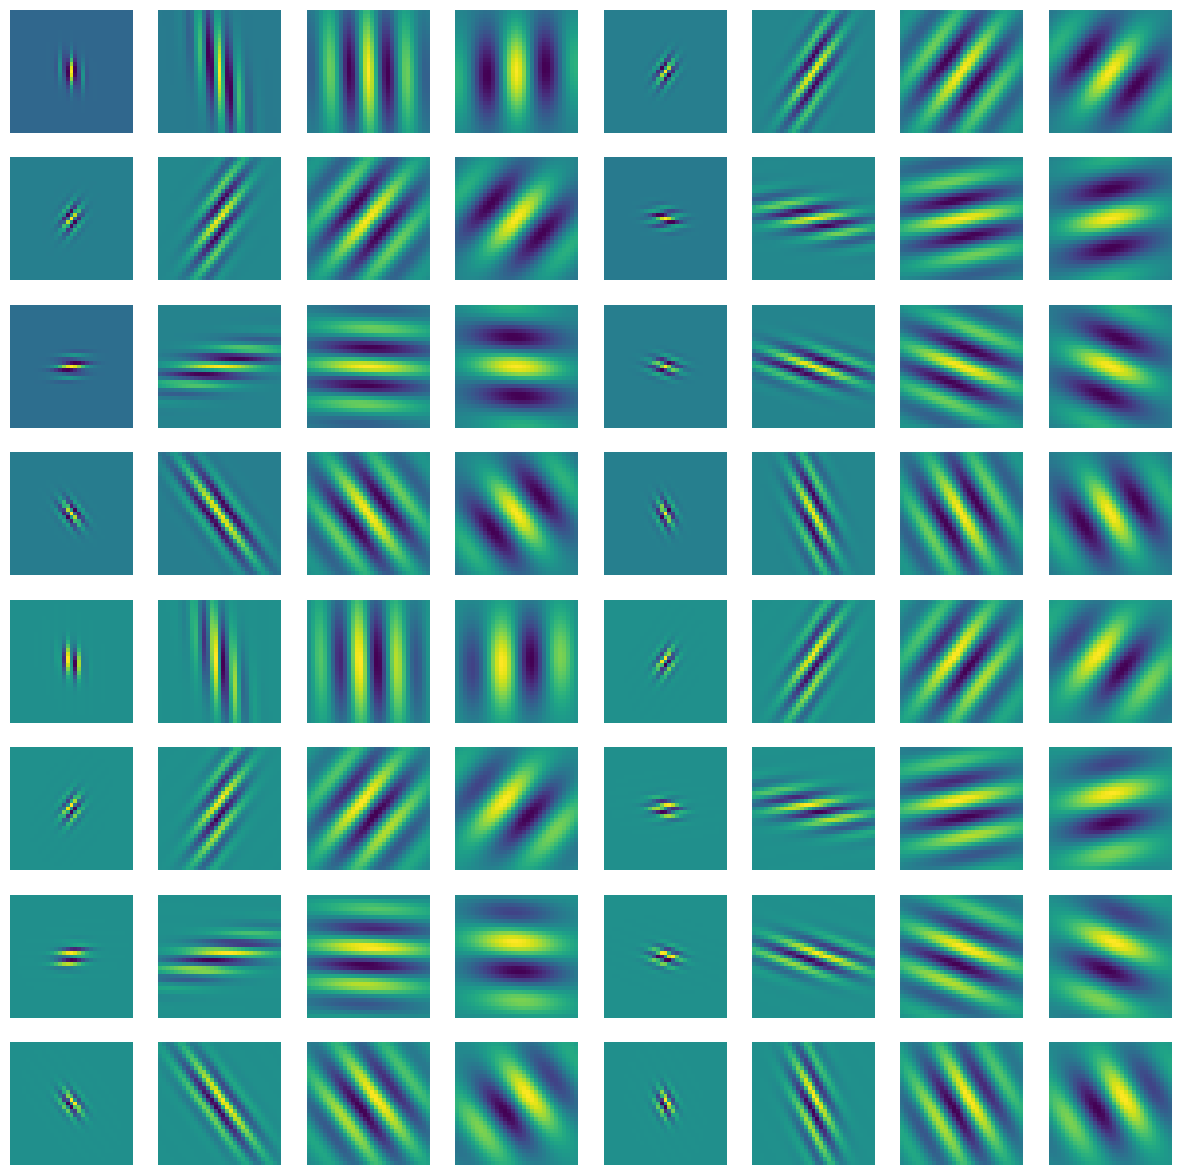

In [122]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(state.state["precalc_filter"][layer_name]["kernel"][:,:,0,i])
    ax.axis("off")
plt.show()

In [123]:
kernel = state.state["precalc_filter"][layer_name]["kernel"]
kernel.shape

(31, 31, 3, 64)

In [124]:
kernel_f_fft = jnp.fft.fftn(kernel[:,:,0,:], axes=(0,1))
kernel_f_fft = jnp.fft.fftshift(kernel_f_fft)
kernel_f_fft_abs_sum = jnp.abs(kernel_f_fft).sum(axis=-1)
kernel_f_fft.shape, kernel_f_fft_abs_sum.shape

((31, 31, 64), (31, 31))

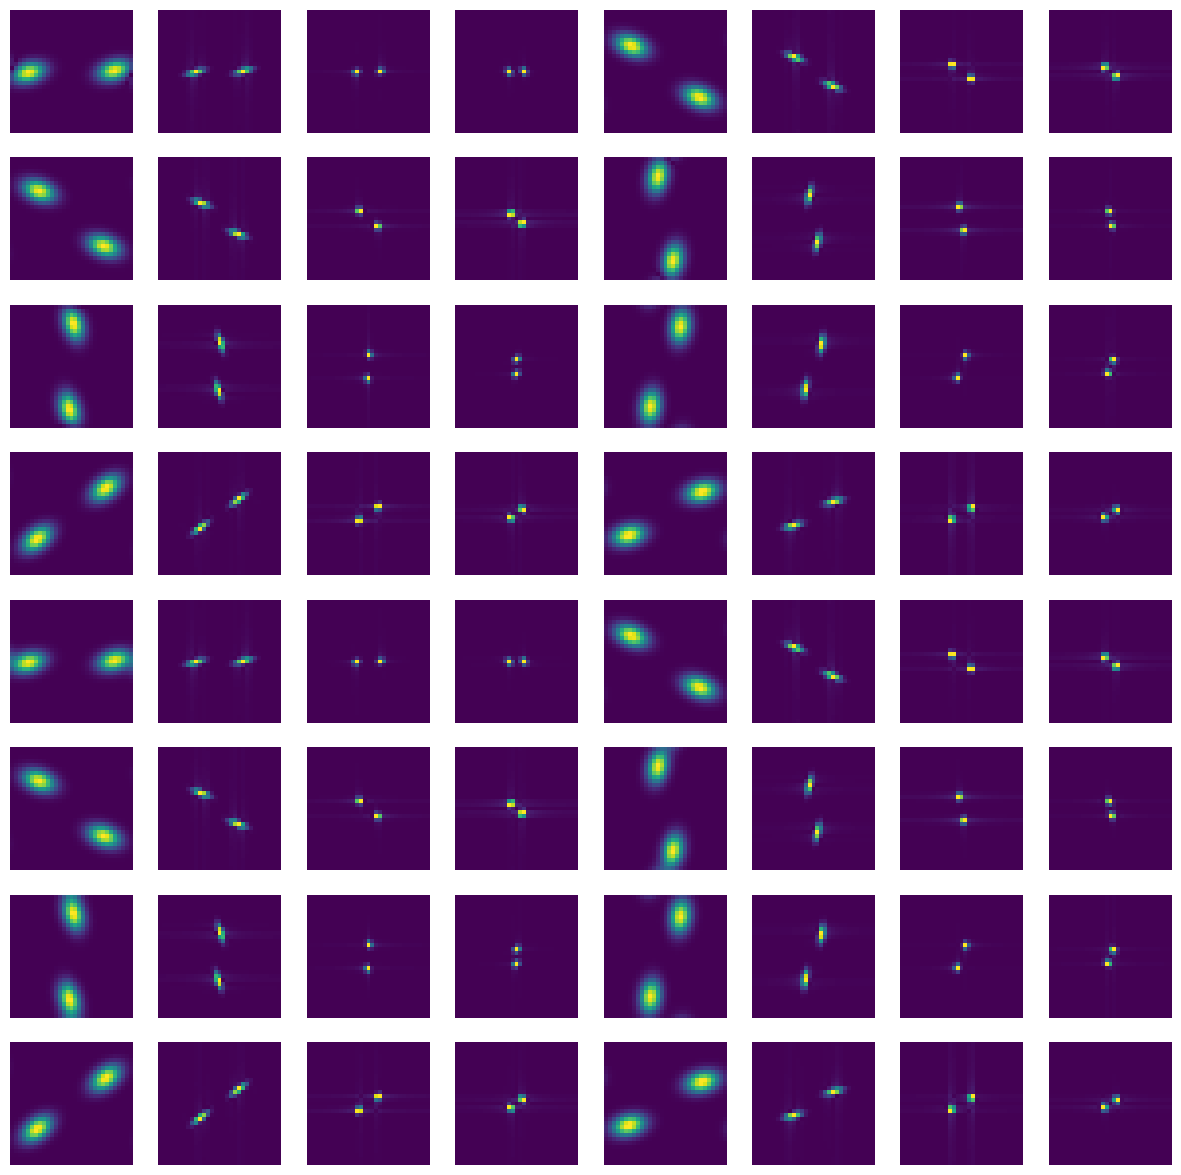

In [125]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(jnp.abs(kernel_f_fft[:,:,i]))
    ax.axis("off")
plt.show()

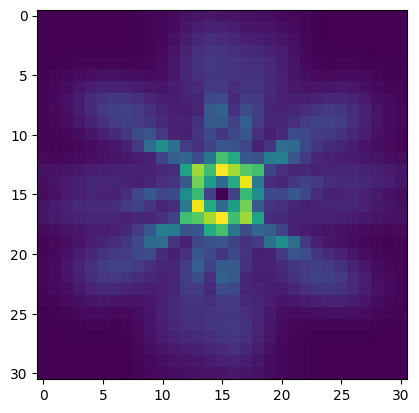

In [126]:
plt.imshow(kernel_f_fft_abs_sum)
plt.show()

### DN (3)

In [128]:
prev_layer = "GaborLayerLogSigma__0"
layer_name = "GDN_3"
state.params[layer_name]

FrozenDict({
    Conv_0: {
        bias: array([0.2372541 , 0.90833837, 1.029847  , 0.64226073, 0.752633  ,
               0.8610895 , 1.0124203 , 0.16127883, 0.86718184, 0.94960517,
               0.5305961 , 0.23943892, 0.694491  , 0.        , 0.78813785,
               0.6323902 , 0.69187963, 1.6218115 , 0.5592346 , 0.8945127 ,
               0.16248772, 0.9515608 , 0.49583846, 0.7368119 , 0.16912225,
               0.9706825 , 0.79580146, 0.813438  , 0.14380042, 0.7572453 ,
               1.0288846 , 1.0388076 , 0.22372031, 0.88924956, 1.0404774 ,
               0.67972326, 0.7523025 , 0.8555221 , 1.0093329 , 0.17490014,
               0.8605979 , 0.92669487, 0.5352521 , 0.20229205, 0.6991246 ,
               0.03986198, 0.86570376, 0.5763817 , 0.67352057, 1.4235383 ,
               0.7161695 , 0.71572924, 0.10502886, 0.9479212 , 0.5204254 ,
               0.6218025 , 0.24031879, 0.97150785, 0.78701067, 0.84336257,
               0.07061716, 0.71204203, 1.0239897 , 1.0817528 ], dty

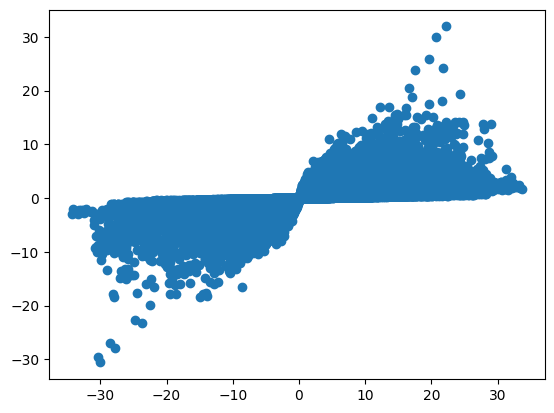

In [131]:
plt.scatter(extras["intermediates"][prev_layer]["__call__"][0][0].ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

### Final output

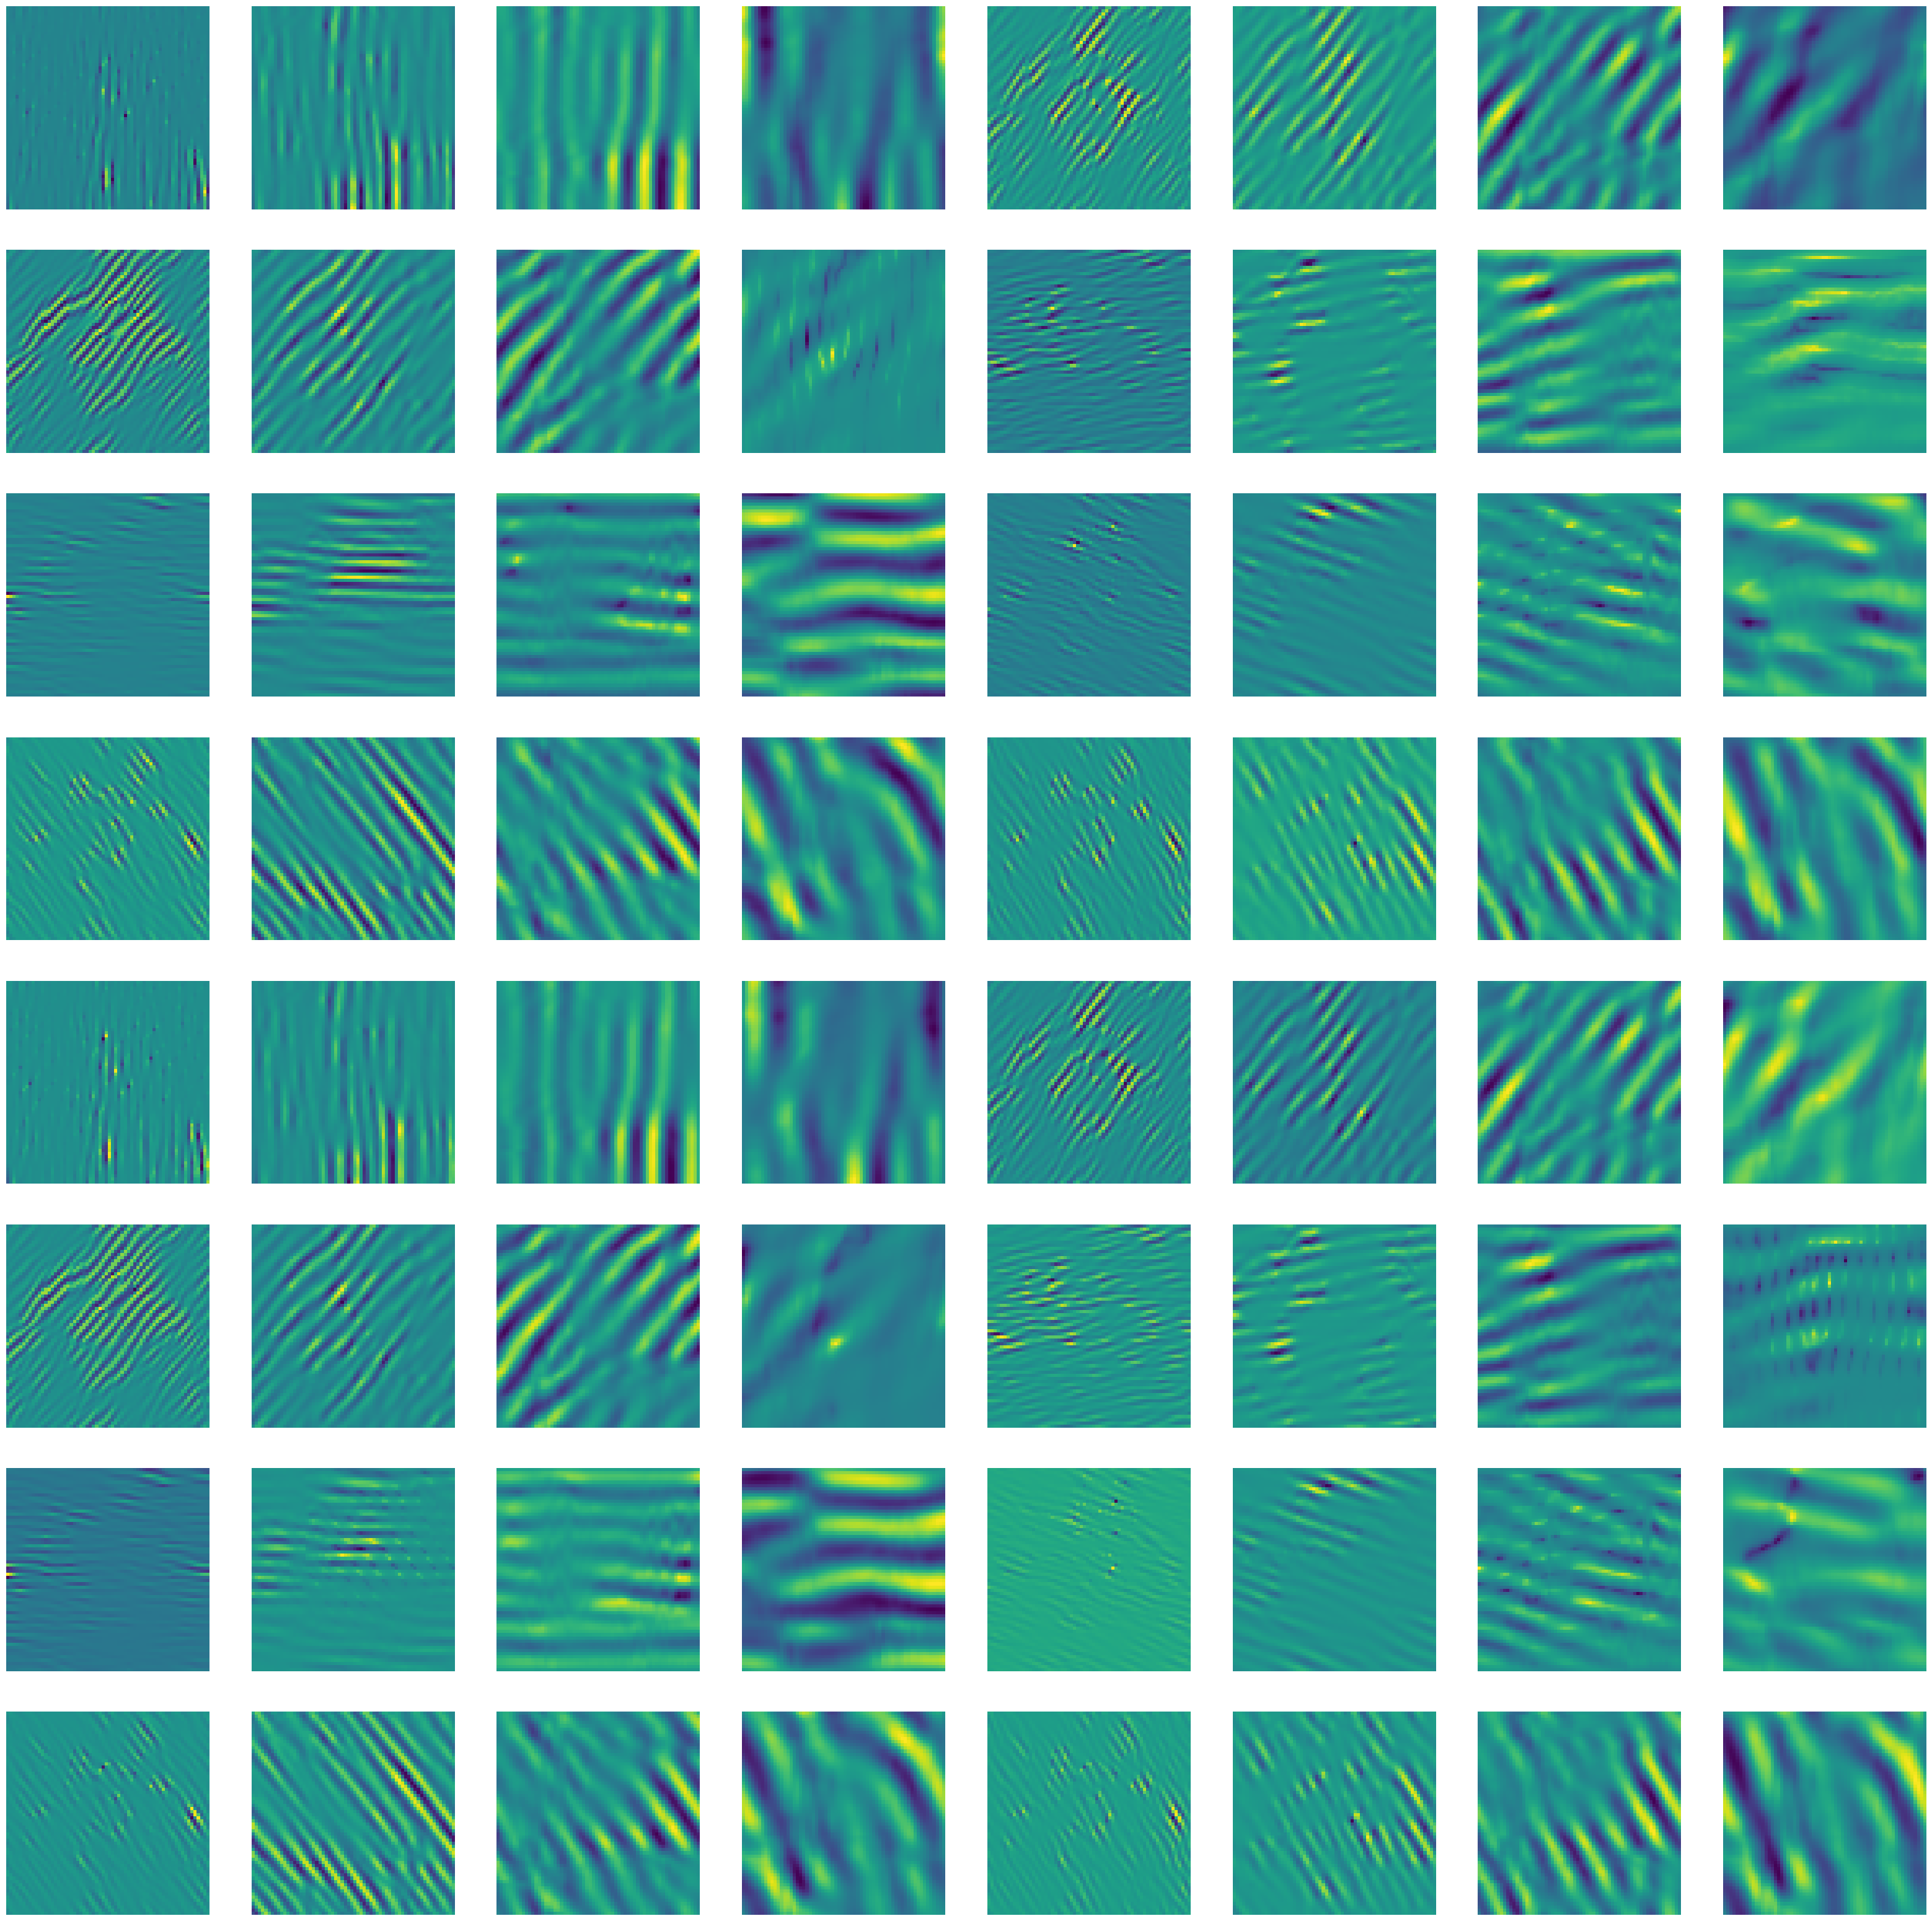

In [132]:
fig, axes = plt.subplots(8,8, figsize=(40,40))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(outputs[0,:,:,i])
    ax.axis("off")
plt.show()